In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import distance
import datetime
import seaborn as sns
import os

import networkx as nx
from networkx.convert_matrix import from_numpy_matrix
from networkx.algorithms import community

sns.set_theme(style="dark")

freq = '19S'
w = 2592
h = 1944
n = len(os.listdir('yolov5/runs/detect/1012_2100/labels/'))

feeding_y_upper = 1165
feeding_y_lower = 1645

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


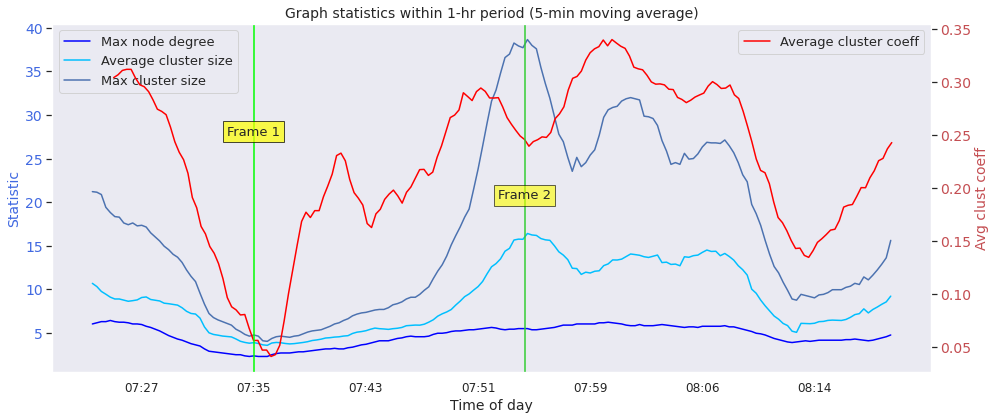

In [2]:
hour = '0700'
# days = ['1013_','1015_','1017_']
day = '1013_'
tick_step = 25
rolling_window = 15
threshold_dist = 150

start = hour[:2] + ":19:26"
# Dataframe to store stats
stats = pd.DataFrame(index=pd.date_range(start=start, periods=n, freq=freq), columns=['Max_deg','Avg_clust_coeff','Avg_clust_size','Max_clust_size'])

for i in range(1, n+1):
    df = pd.read_csv('yolov5/runs/detect/{}{}/labels/2020{}{}_{}.txt'.format(day,hour,day,hour,i), header=None, sep=' ', usecols=[1,2], names=['x','y'])
    df['x'] = (df['x']*w).astype(int)
    df['y'] = (df['y']*h).astype(int)
    
    # Filter out feeding areas and distortion
    df2 = df[(df['y']<1165)&(df['x']>233)&(df['x']<2339)]

    dm = distance.squareform(distance.pdist(df2.values))
    # Pruned graph
    G = from_numpy_matrix(np.where(dm<threshold_dist, dm, 0))

    # Max deg
    stats.iloc[i-1,0] = max(dict(G.degree).values())
    # Avg clustering coeff
    stats.iloc[i-1,1] = nx.average_clustering(G)
    # Communities
    comms = community.greedy_modularity_communities(G)
    pruned_comms = list(map(len, filter(lambda x: len(x)>2, comms))) # List of communities
    try:
        stats.iloc[i-1,2] = np.mean(pruned_comms)
        stats.iloc[i-1,3] = max(pruned_comms)
    except:
        stats.iloc[i-1,2] = 0
        stats.iloc[i-1,3] = 0

stats['Time'] = stats.index.to_pydatetime()
stats['Time'] = stats['Time'].apply(lambda x: str(datetime.datetime.time(x)))

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(stats['Time'], stats['Max_deg'].rolling(rolling_window).mean(), label='Max node degree', color='blue')
ax1.plot(stats['Time'], stats['Avg_clust_size'].rolling(rolling_window).mean(), label='Average cluster size', color='deepskyblue')
ax1.plot(stats['Time'], stats['Max_clust_size'].rolling(rolling_window).mean(), label='Max cluster size')

ax1.set_xlabel('Time of day', fontsize=14)
ax1.set_ylabel('Statistic', fontsize=14, color='royalblue')
ax1.set_xticks(stats['Time'][::tick_step])
ax1.set_xticklabels([t[:-3] for t in stats['Time'][::tick_step]], fontsize=12)
ax1.tick_params(axis='y', labelsize=14, labelcolor='royalblue')

ax2 = ax1.twinx()
ax2.plot(stats['Time'], stats['Avg_clust_coeff'].rolling(rolling_window).mean(), label='Average cluster coeff', color='red')
ax2.set_ylabel('Avg clust coeff', fontsize=14, color='r')
ax2.tick_params(axis='y', labelsize=14, labelcolor='r')
ax2.set_xticks(stats['Time'][::tick_step])
ax2.set_xticklabels([t[:-3] for t in stats['Time'][::tick_step]], fontsize=12)

plt.axvline(x='07:53:38', c='limegreen')
plt.axvline(x='07:34:00', c='lime')
plt.text('07:32:06',0.25,'Frame 1',fontsize=13, bbox=dict(facecolor='yellow', edgecolor='black', alpha=0.7))
plt.text('07:51:44',0.19,'Frame 2',fontsize=13, bbox=dict(facecolor='yellow', edgecolor='black',alpha=0.6))

plt.title('Graph statistics within 1-hr period ({}-min moving average)'.format(int(rolling_window/3)), fontsize=14)
ax1.legend(loc='upper left', fontsize=13)
ax2.legend(loc='upper right', fontsize=13)
fig.tight_layout()
# plt.show()
plt.savefig('graph_statistics.png')

In [3]:
stats

,Max_deg,Avg_clust_coeff,Avg_clust_size,Max_clust_size,Time
2022-04-17 07:19:26,5,0.261111,14,18,07:19:26
2022-04-17 07:19:45,5,0.301916,15.8,20,07:19:45
2022-04-17 07:20:04,5,0.327273,13,37,07:20:04
2022-04-17 07:20:23,5,0.283333,13.3333,24,07:20:23
2022-04-17 07:20:42,7,0.386731,13,24,07:20:42
...,...,...,...,...,...
2022-04-17 08:18:58,5,0.220139,10.6667,16,08:18:58
2022-04-17 08:19:17,5,0.295333,9.25,16,08:19:17
2022-04-17 08:19:36,6,0.207738,10,17,08:19:36
2022-04-17 08:19:55,6,0.263743,11.6667,22,08:19:55


Actual
7:33:46 frame 47
7:53:05 102

In [9]:
a=stats[['Max_deg','Avg_clust_coeff','Avg_clust_size','Max_clust_size']]

In [21]:
np.corrcoef(a,rowvar=Tr)

""
